In [1]:
from keras.models import load_model, Model
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import argparse
import os, sys, pysam
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import logomaker
import seaborn as sns



In [2]:
genome_file = '/Users/datn/GENOMES/cattle/Bos_taurus.ARS-UCD1.2.dna.toplevel.fa'
model_file = 'model_weights/cattle_DanQ.h5'
out_file = 'out_tables/test.txt'

In [3]:

embed = np.zeros([256, 4], np.float16)
embed[ord('A')] = np.array([1, 0, 0, 0])
embed[ord('C')] = np.array([0, 1, 0, 0])
embed[ord('G')] = np.array([0, 0, 1, 0])
embed[ord('T')] = np.array([0, 0, 0, 1])
embed[ord('N')] = np.array([0, 0, 0, 0])
embed[ord('a')] = np.array([1, 0, 0, 0])
embed[ord('c')] = np.array([0, 1, 0, 0])
embed[ord('g')] = np.array([0, 0, 1, 0])
embed[ord('t')] = np.array([0, 0, 0, 1])
embed[ord('n')] = np.array([0, 0, 0, 0])
embed[ord('.')] = np.array([.25, .25, .25, .25])
embed = tf.convert_to_tensor(embed)


def one_hot_encode_seq(dna_input, numpy = False,  name = "encode_seq"):
  with tf.name_scope(name):
    b = bytearray()
    b.extend(map(ord, str(dna_input)))
    t = tf.convert_to_tensor(b)
    t = tf.cast(t, tf.int32)
    encoded_dna = tf.nn.embedding_lookup(embed, t)
  if numpy == True: 
    return encoded_dna.numpy()
  else:
    return encoded_dna


## fast way to do reverse complement
tab = str.translate("ATGCatgc", "TACGtacg")
def reverse_complement_table(seq):
    return seq.translate(tab)[::-1]


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [4]:
def seq_profiler(in_seq, pick_tracks = [], model_len = 1000):
    ref_list, A_list, C_list, G_list, T_list = [], [], [], [], []
    L = len(in_seq)
    #model_len = 1000
    # nuc_list = ['A', 'C', 'G', 'T']
    for i in range(0, L):
        #seq = in_seq
        #ref = list(seq)
        
        A_alt = list(in_seq)
        C_alt = list(in_seq)
        G_alt = list(in_seq)
        T_alt = list(in_seq)
    
        A_alt[i] = 'A'
        C_alt[i] = 'C'
        G_alt[i] = 'G'
        T_alt[i] = 'T'
    
        ref = in_seq
        A_alt = ''.join(A_alt)
        C_alt = ''.join(C_alt)
        G_alt = ''.join(G_alt)
        T_alt = ''.join(T_alt)
        
        ref_list.append(one_hot_encode_seq(ref))
        
        A_list.append(one_hot_encode_seq(A_alt))
        C_list.append(one_hot_encode_seq(C_alt))
        G_list.append(one_hot_encode_seq(G_alt))
        T_list.append(one_hot_encode_seq(T_alt))

    
    ref_list = tf.stack(ref_list)
    A_list = tf.stack(A_list)
    C_list = tf.stack(C_list)
    G_list = tf.stack(G_list)
    T_list = tf.stack(T_list)
  

    if len(pick_tracks) > 0:
        ref_pred = model.predict(ref_list, batch_size = 200, verbose = 0)[:,pick_tracks]
        A_pred = model.predict(A_list, batch_size = 200, verbose = 0)[:,pick_tracks]
        C_pred = model.predict(C_list, batch_size = 200, verbose = 0)[:,pick_tracks]
        G_pred = model.predict(G_list, batch_size = 200, verbose = 0)[:,pick_tracks]
        T_pred = model.predict(T_list, batch_size = 200, verbose = 0)[:,pick_tracks]
    else:
        ref_pred = model.predict(ref_list, batch_size = 200, verbose = 0)
        A_pred = model.predict(A_list, batch_size = 200, verbose = 0)
        C_pred = model.predict(C_list, batch_size = 200, verbose = 0)
        G_pred = model.predict(G_list, batch_size = 200, verbose = 0)
        T_pred = model.predict(T_list, batch_size = 200, verbose = 0)
    
    dif_A = ref_pred - A_pred
    dif_C = ref_pred - C_pred
    dif_G = ref_pred - G_pred
    dif_T = ref_pred - T_pred
    


    #dif_A = dif_A.mean(1)
    #dif_C = dif_C.mean(1)
    #dif_G = dif_G.mean(1)
    #dif_T = dif_T.mean(1)
    
    #all_dif = np.concatenate([dif1_max, dif2_max, dif3_max], axis = 0)
    #all_dif = all_dif.reshape(-1,3)

    return dif_A, dif_C, dif_G, dif_T

In [5]:
model = load_model(model_file)
ref_genome = pysam.FastaFile(genome_file)

# Regulatory variant from this paper:

https://pmc.ncbi.nlm.nih.gov/articles/PMC7613894/figure/F6/

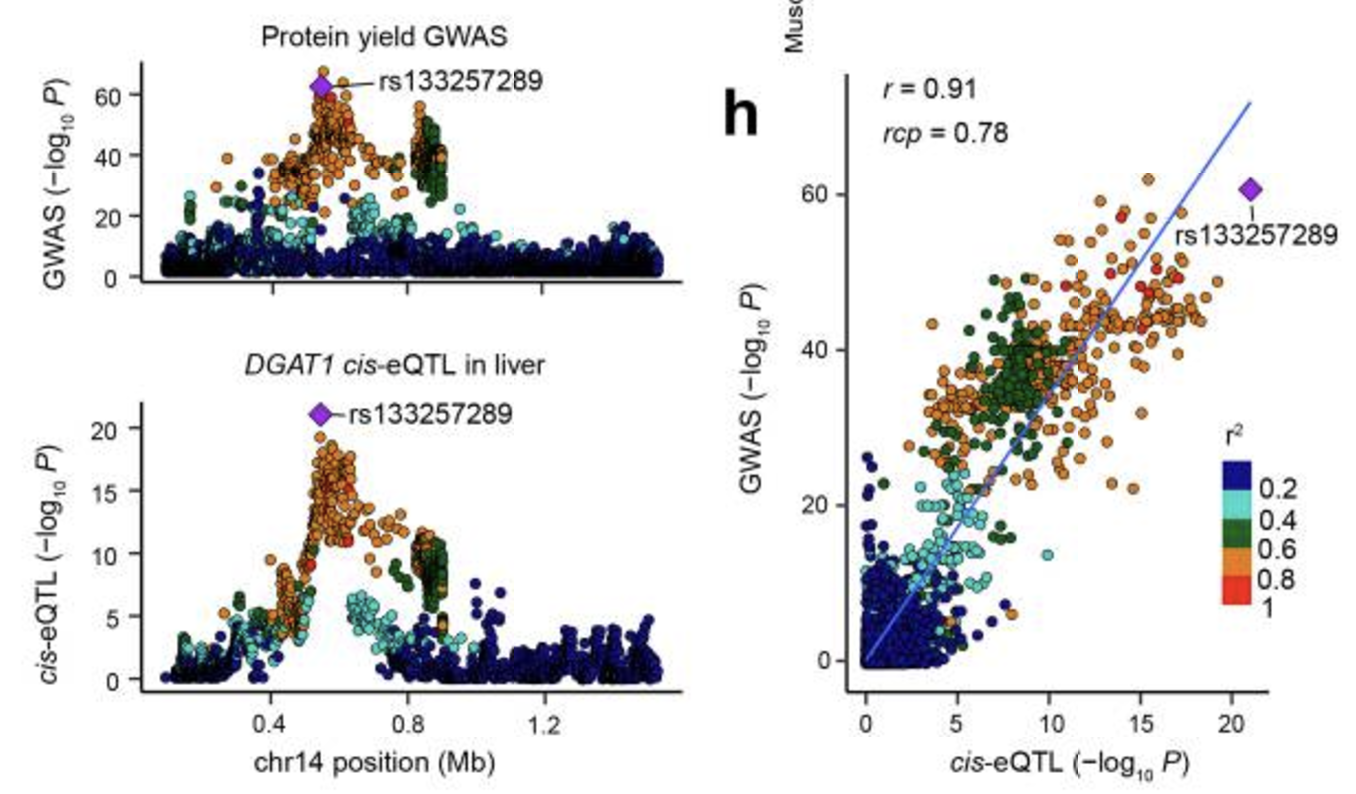

In [6]:
c = '14'
p = 544162

In [7]:
s = 500
my_seq = ref_genome.fetch(c, p -s, p +s)

In [8]:
dif_A, dif_C, dif_G, dif_T = seq_profiler(my_seq, pick_tracks=[7,8])

2024-12-26 22:31:11.237244: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
dif_A = dif_A.mean(1)
dif_C = dif_C.mean(1)
dif_G = dif_G.mean(1)
dif_T = dif_T.mean(1)

In [10]:
all_dif = np.concatenate([dif_A, dif_C, dif_G, dif_T], axis = 0)

In [11]:
all_dif = all_dif.reshape(4,-1)

In [12]:
seq_1hot = one_hot_encode_seq(my_seq)

In [13]:
scores = all_dif.T

In [14]:
viz_len=200
ymin=-np.inf
ymax=np.inf

In [16]:
def plot_logo(scores, seq_1hot, viz_len=None, ymin=-np.inf, ymax=np.inf):
    if viz_len is not None and viz_len < seq_1hot.shape[0]:
        mid_pos = seq_1hot.shape[0]//2
        viz_start = mid_pos - viz_len//2
        viz_end = viz_start + viz_len
        scores = scores[viz_start:viz_end]
        seq_1hot = seq_1hot[viz_start:viz_end]
        
    scores = np.clip(scores, ymin, ymax)
    
    fig, axs = plt.subplots(3, 1, figsize=(14,6), sharex='col', 
                            gridspec_kw={'height_ratios': [2, 4, 5]}, constrained_layout = True)
    #fig, axs = plt.subplots(3, 1, figsize=(20,10), gridspec_kw={'height_ratios': [1, 5, 5]})  
    
    loss = scores.max(1)
    gain = scores.min(1)
    gain = np.abs(gain)
    #gain_df = pd.DataFrame( {'loss': loss, 'gain' : gain})
    gain_df = pd.DataFrame( {'gain' : gain, 'loss': loss,})
    
    sns.lineplot(gain_df, ax=axs[1])
    axs[1].set_ylabel('\u0394 pred')
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    
    m = gain_df.max(1)
    m = np.tile(m, 4).reshape(4,viz_len).T
    seq_df = pd.DataFrame(seq_1hot*m, columns=['A','C','G','T'])
    seq_logo = logomaker.Logo(seq_df, ax=axs[0])
    axs[0].axis('off')


    sns.heatmap(scores.T, center=0, ax=axs[2], cmap='RdBu_r', linewidths=0, xticklabels=False)
    #sns.heatmap(scores.T, center=0, ax=axs[2], cmap='RdBu_r', 
    #xticklabels=False, cbar_kws = dict(use_gridspec=False, location="top"))
    axs[2].set_yticklabels('ACGT')
    
    

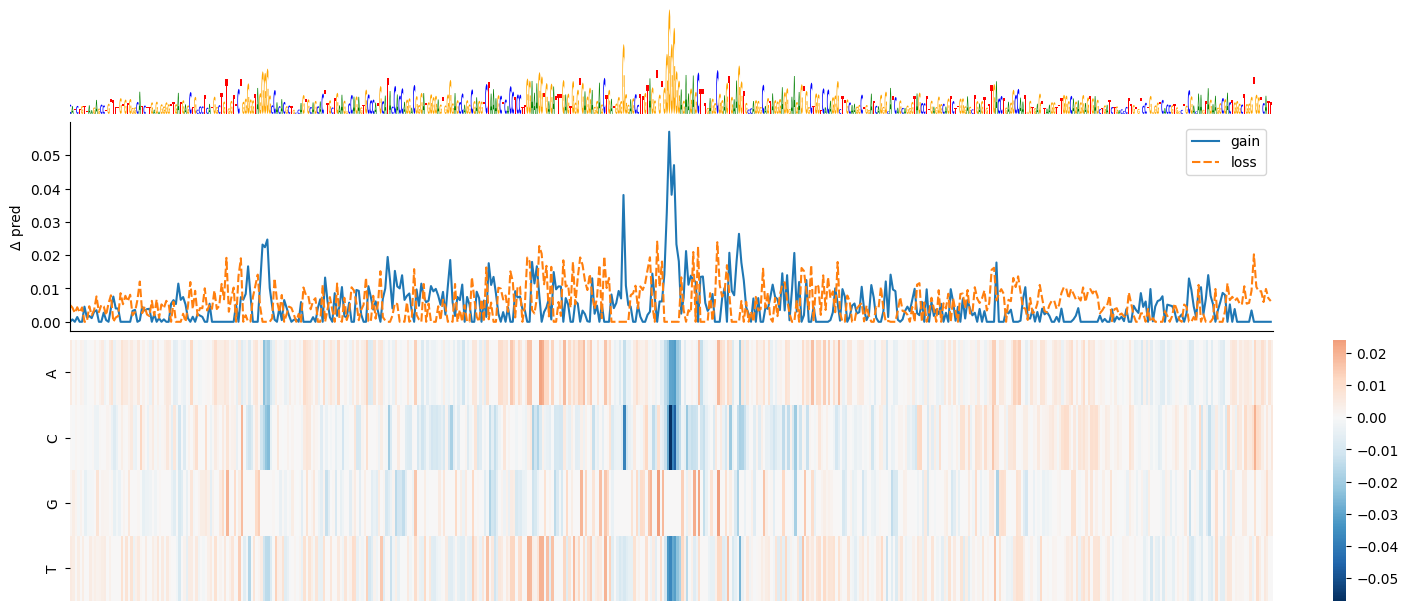

In [17]:

plot_logo(scores, seq_1hot, 500)
plt.savefig('out_figs/SAD_rs133257289_500.pdf', format='pdf')

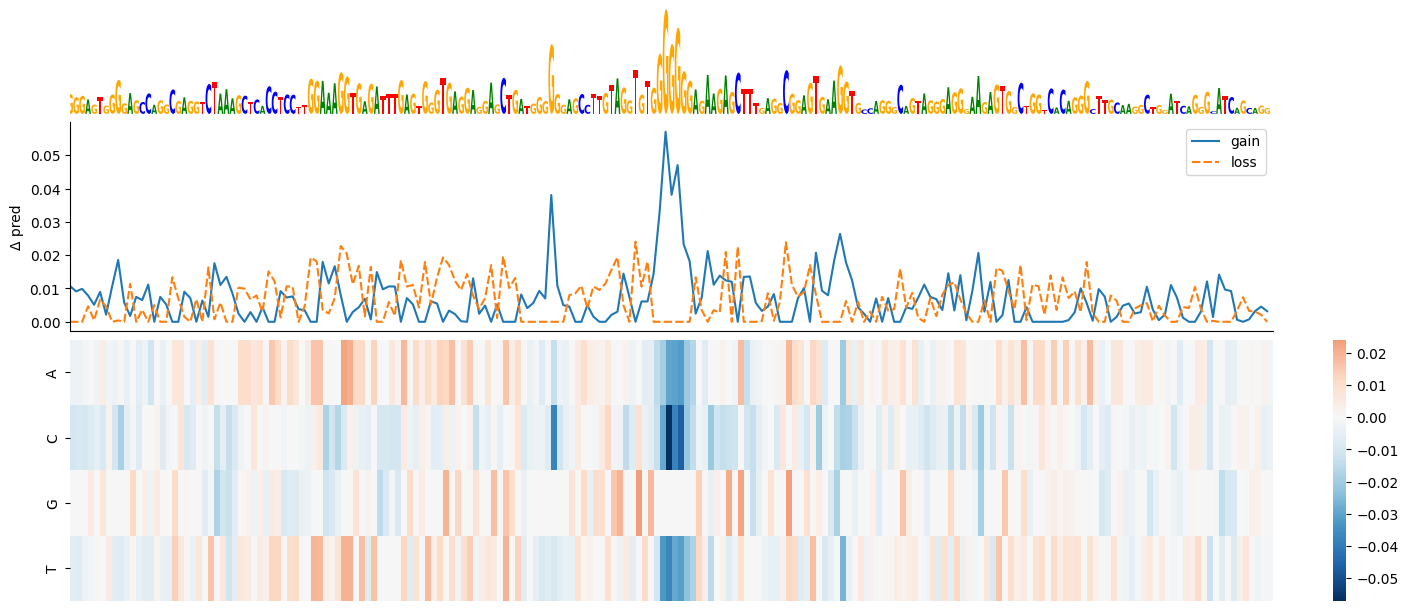

In [18]:

plot_logo(scores, seq_1hot, 200)
plt.savefig('out_figs/SAD_rs133257289_200.pdf', format='pdf')

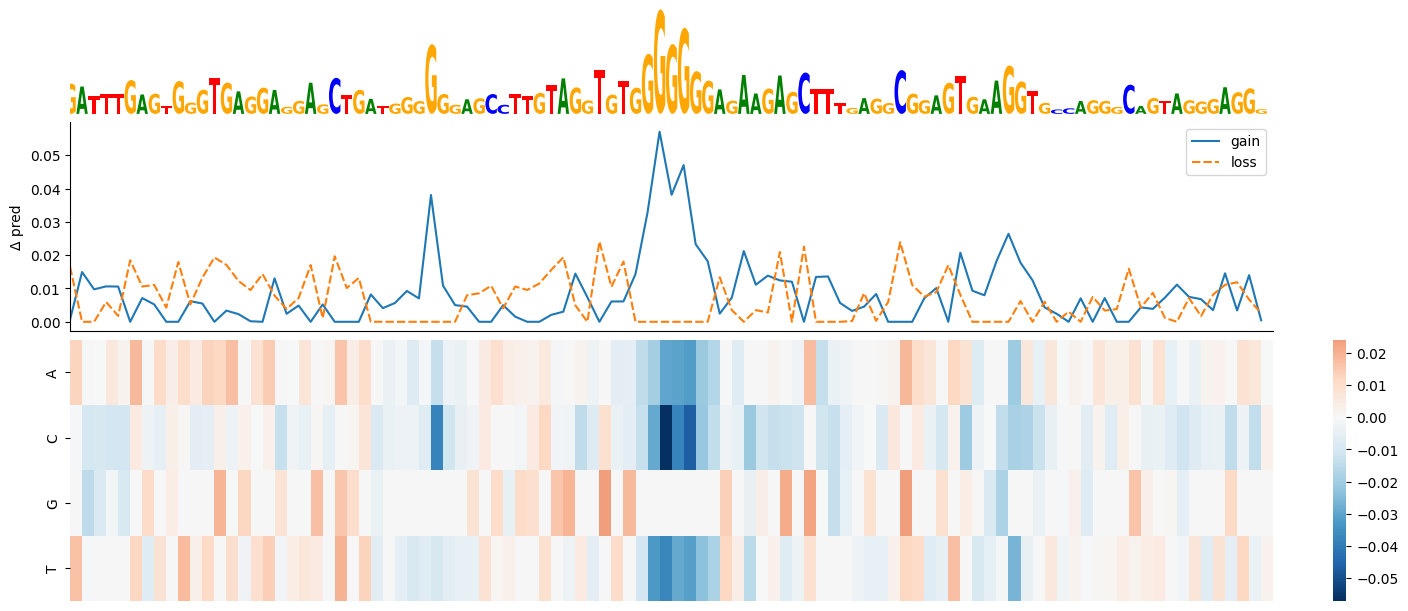

In [19]:

plot_logo(scores, seq_1hot, 100)
plt.savefig('out_figs/SAD_rs133257289_100.pdf', format='pdf')

In [21]:
scores.shape

(1000, 4)